<a href="https://colab.research.google.com/github/hparten/DS6050/blob/main/zsk4gm_codeathon_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Hallie Parten | zsk4gm | DS6050**

**Codeathon 1**

*February 17, 2024*

Code in this assignment was adapted from the *TensorFLow Image Classfication* tutorial (https://www.tensorflow.org/tutorials/images/classification) and the *TensorFlow Transfer Learning and Fine Tuning* tutorial (https://www.tensorflow.org/tutorials/images/transfer_learning?hl=en).

In [2]:
#install packages
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
#download data
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')

228813984/228813984 [==============================] - 2s 0us/step


In [4]:
#view images
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


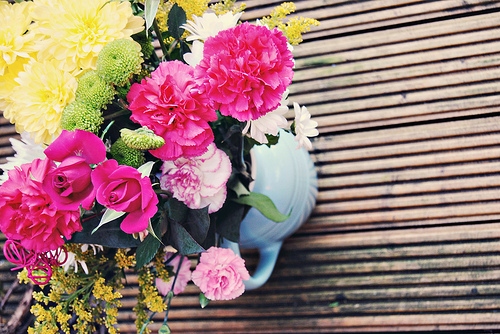

In [5]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

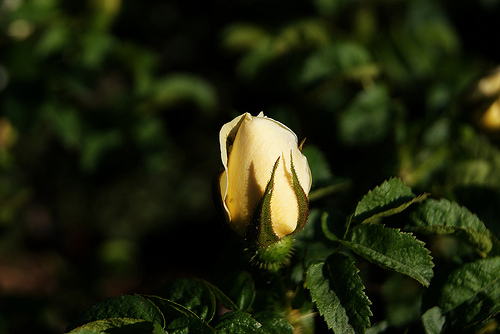

In [6]:
PIL.Image.open(str(roses[1]))

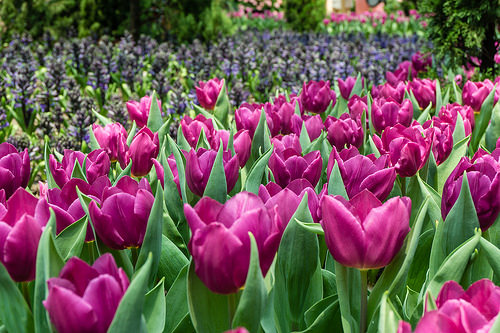

In [7]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

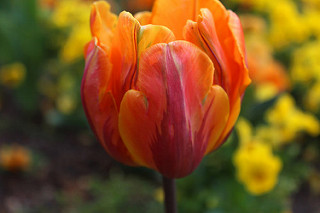

In [8]:
PIL.Image.open(str(tulips[1]))

In [47]:
#load as a tf.data.Dataset using Keras
#parameters for the loader
batch_size = 32
img_height = 180
img_width = 180
img_size = (img_width, img_height)

(180, 180)

In [10]:
#create 80/20 validation split
#train set
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [11]:
#validation set
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [12]:
#inspect class_names attribute
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


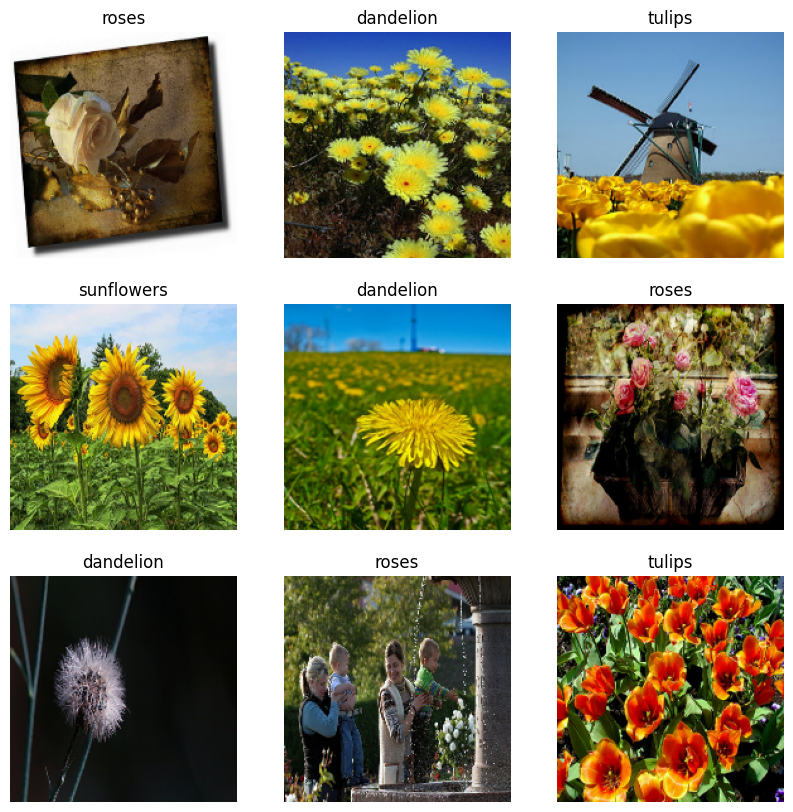

In [13]:
#explore dataset
#first nine images in train set

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape) #tensor batch of 32 images of shape 180x180x3
  #the '3' refers to color channels RGB
  print(labels_batch.shape)
  #tensor batch corresponding to the 32 images
  break

(32, 180, 180, 3)
(32,)


In [19]:
#dataset.cache keeps images in memory after first epoch
#dataset.prefetch ovrelaps preprocessing and execution in training

In [20]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [27]:
#scale RGB values betwee [0,1]
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))
#can include resizing layer in the model using tf.keras.layers.rescaling...
#this is the approach below

0.0 1.0


In [36]:
#define model
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)#output neurons
])

In [29]:
#compile model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Model 1 - no regularization

In [30]:
#summarize model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [31]:
#train model
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 56s 593ms/step - loss: 1.4147 - accuracy: 0.3777 - val_loss: 1.1204 - val_accuracy: 0.5504
Epoch 2/10
92/92 [==============================] - 59s 636ms/step - loss: 1.0388 - accuracy: 0.5869 - val_loss: 1.1081 - val_accuracy: 0.5640
Epoch 3/10
92/92 [==============================] - 58s 626ms/step - loss: 0.8577 - accuracy: 0.6689 - val_loss: 0.9665 - val_accuracy: 0.6076
Epoch 4/10
92/92 [==============================] - 62s 670ms/step - loss: 0.6541 - accuracy: 0.7589 - val_loss: 0.9794 - val_accuracy: 0.6294
Epoch 5/10
92/92 [==============================] - 54s 591ms/step - loss: 0.4676 - accuracy: 0.8307 - val_loss: 1.0012 - val_accuracy: 0.6390
Epoch 6/10
92/92 [==============================] - 60s 652ms/step - loss: 0.2777 - accuracy: 0.9125 - val_loss: 1.2925 - val_accuracy: 0.6376
Epoch 7/10
92/92 [==============================] - 55s 590ms/step - loss: 0.1832 - accuracy: 0.9428 - val_loss: 1.3462 - val_accuracy: 0.6226

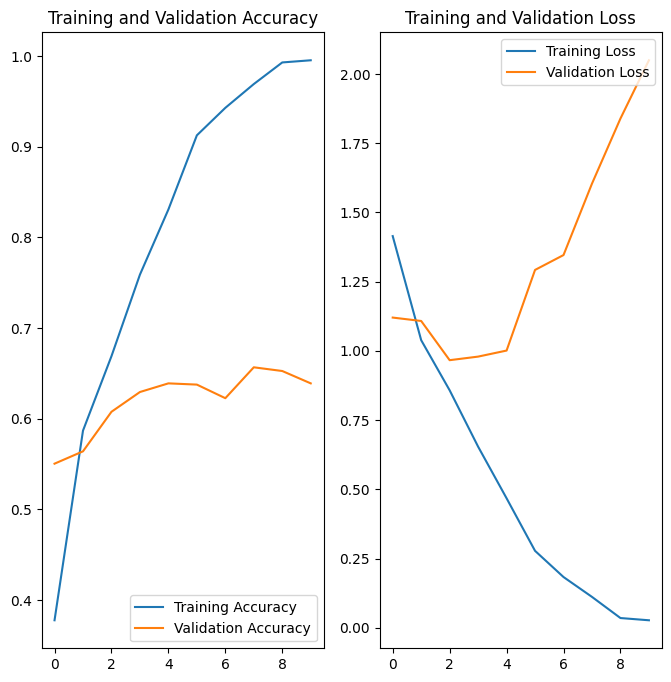

In [32]:
#plot accuracy+loss on train+validation sets
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### There is clear evidence of overfitting in the performance of this model because the training accuracy is so much higher than the validation accuracy. In the next model, we attempt two methods to mitigate overftting - data augmentation & dropout.

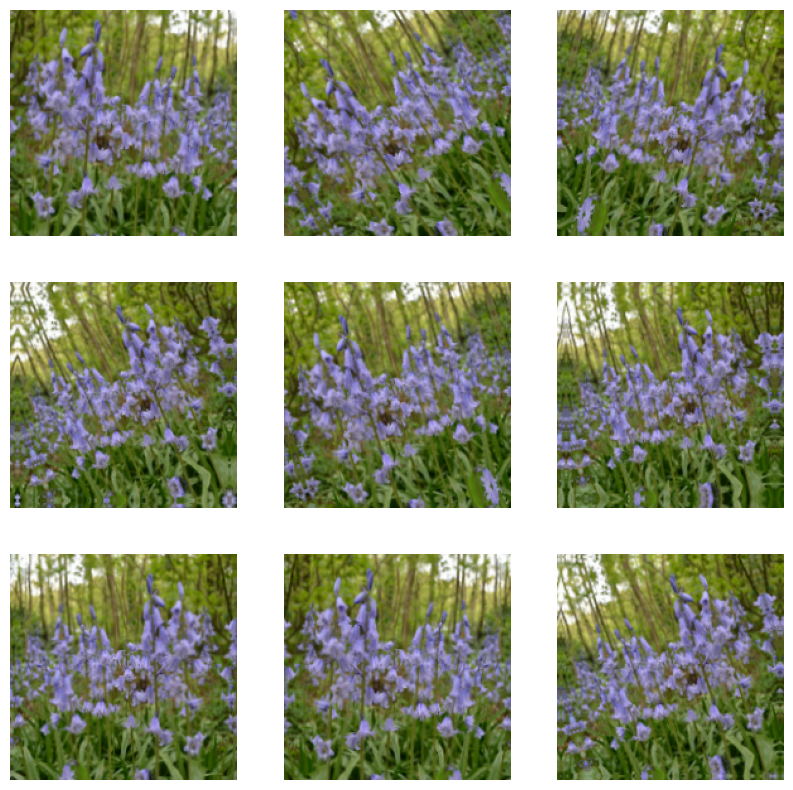

In [33]:
#training and validation accuracy differ by large margins ->
#fix overfitting
#method 1 - data augmentation
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

# Model 2 - Data Augmentation & Dropout

In [40]:
#method 2 - dropout
#randomly drops out (by setting activation to zero) a number of
#output units from the layer during training
#define model with augmentation and dropout
model_aug_drop = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])
#compile model with augmentation and dropout
model_aug_drop.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
#summarize model with augmentation and dropout
model_aug_drop.summary()
#train model with augmentation and dropout
epochs=15
history_aug_drop = model_aug_drop.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_8 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                

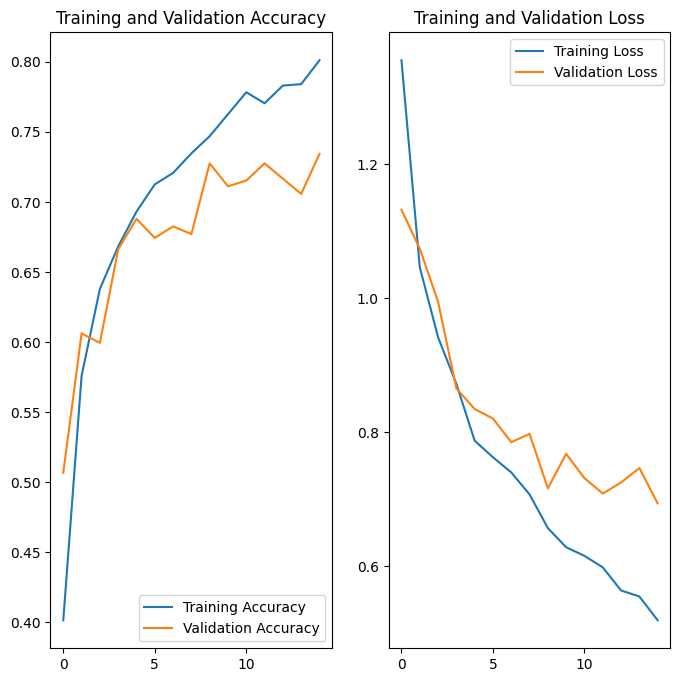

In [43]:
acc_aug_drop = history_aug_drop.history['accuracy']
val_acc_aug_drop = history_aug_drop.history['val_accuracy']

loss_aug_drop = history_aug_drop.history['loss']
val_loss_aug_drop = history_aug_drop.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_aug_drop, label='Training Accuracy')
plt.plot(epochs_range, val_acc_aug_drop, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_aug_drop, label='Training Loss')
plt.plot(epochs_range, val_loss_aug_drop, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### The performance of model 2 is improved, we see that the gap between the training accuracy and the validation accuracy has been lessened. The higher training accuracy still indicates that overfitting is occuring; in the next model we employ transfer learning - feature extraction using Google's MobileNet V2 model.

In [44]:
#predict on new data
#data augmentation and dropout layers are inactive at inference
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model_aug_drop.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 92ms/step
This image most likely belongs to sunflowers with a 99.25 percent confidence.


### This model does perform well on the task of predicting an image of a sunflower, however we still want to improve the overall validation accuracy of the model

In [49]:
#transfer learning
#base model from the pre-trained convnets: MobileNet V2
#use the "bottleneck layer" (the second-to-last layer) bc these features
#retain more generality
# Create the base model from the pre-trained model MobileNet V2
img_shape = img_size + (3,) #bc it's made of pixels
base_model = tf.keras.applications.MobileNetV2(input_shape=img_shape,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [50]:
#test the feature extrator on example batch of images
image_batch, labels_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 6, 6, 1280)


In [53]:
#freeze the convolutional base (the pretrained top layers)
base_model.trainable = False

In [78]:
#convert features to single 1280-element vector per image
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [71]:
#preprocess input layer
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# Model 3 - Transfer Learning - Feature Extraction

In [91]:
#build transfer model
inputs = tf.keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = preprocess_input(x) #include bc base model expects pixel values in [-1,1]
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(num_classes)(x)
model_transfer = tf.keras.Model(inputs, outputs)

model_transfer.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 tf.math.truediv_14 (TFOpLa  (None, 180, 180, 3)       0         
 mbda)                                                           
                                                                 
 tf.math.subtract_14 (TFOpL  (None, 180, 180, 3)       0         
 ambda)                                                          
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 6, 6, 1280)        2257984   
 tional)                                                         
                                                           

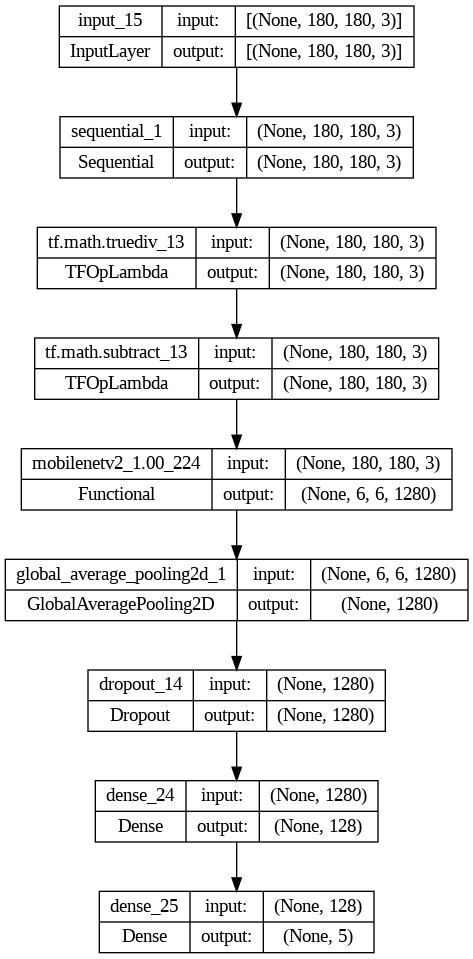

In [88]:
tf.keras.utils.plot_model(model_transfer, show_shapes=True)

In [92]:
#compile transfer model
model_transfer.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [93]:
#train transfer model
transfer_epochs = 10

history_transfer = model_transfer.fit(
  train_ds,
  validation_data=val_ds,
  epochs=transfer_epochs)

Epoch 1/10
92/92 [==============================] - 64s 666ms/step - loss: 0.6408 - accuracy: 0.7592 - val_loss: 0.4120 - val_accuracy: 0.8569
Epoch 2/10
92/92 [==============================] - 60s 649ms/step - loss: 0.4142 - accuracy: 0.8512 - val_loss: 0.3520 - val_accuracy: 0.8747
Epoch 3/10
92/92 [==============================] - 59s 640ms/step - loss: 0.3363 - accuracy: 0.8736 - val_loss: 0.3637 - val_accuracy: 0.8733
Epoch 4/10
92/92 [==============================] - 60s 651ms/step - loss: 0.3154 - accuracy: 0.8794 - val_loss: 0.3418 - val_accuracy: 0.8828
Epoch 5/10
92/92 [==============================] - 59s 647ms/step - loss: 0.2879 - accuracy: 0.8948 - val_loss: 0.3416 - val_accuracy: 0.8774
Epoch 6/10
92/92 [==============================] - 60s 651ms/step - loss: 0.2596 - accuracy: 0.9043 - val_loss: 0.3409 - val_accuracy: 0.8896
Epoch 7/10
92/92 [==============================] - 61s 662ms/step - loss: 0.2338 - accuracy: 0.9087 - val_loss: 0.3469 - val_accuracy: 0.8924

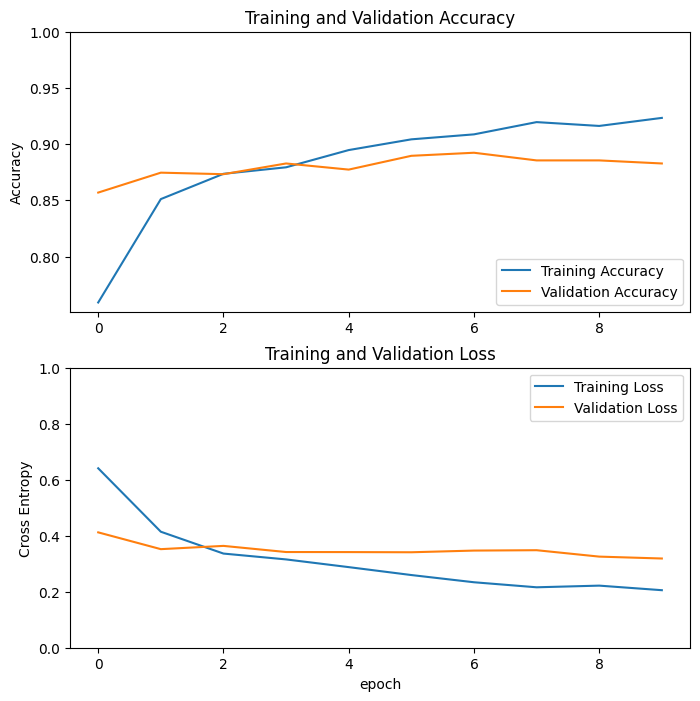

In [94]:
#results with transfer learning model
acc_transfer = history_transfer.history['accuracy']
val_acc_transfer = history_transfer.history['val_accuracy']

loss_transfer = history_transfer.history['loss']
val_loss_transfer = history_transfer.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc_transfer, label='Training Accuracy')
plt.plot(val_acc_transfer, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss_transfer, label='Training Loss')
plt.plot(val_loss_transfer, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### The reason the validation metrics look much better than the training metrics for the first 5 epochs is because the data augmentation and dropout make the model more robust to variations in the training data, but these layers are turned off when calculating validation loss.

## We see here that our validation accuracy was improved greatly by extracting the features of the MobileNet V2 base model in training.

## For our fourth, and final, model, we will fine tune the layers in the pre-trained network to features associated specifically with the dataset. We will only attempt to fine-tune a small number of the top layers.

In [95]:
#predict on sunflower image
predictions = model_transfer.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 1s 617ms/step
This image most likely belongs to sunflowers with a 100.00 percent confidence.


### Model 3 now predicts our test image with 100% confidence.

In [96]:
#fine-tuning model
#unfreeze the top layers of the model
base_model.trainable = True

In [97]:
## of layers in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [98]:
#define top layers to begin fine-tuning
fine_tune_at = 100

In [99]:
#freeze all layers before fine_tune_at
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [100]:
#fine-tune the weights of the top layers of the pre-trained model
#define a small learning rate bc much larger model that could overfit quickly
base_learning_rate = 0.00001 #instead of default of 0.001

#compile transfer model
model_transfer.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                       loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                       metrics=['accuracy'])

In [103]:
len(model_transfer.trainable_variables) #increased from 2 bc we added the layers in the pre-trained model

58

In [106]:
#early-stopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Metric to monitor for improvement
    patience=5,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True
)

# Model 4 - Fine-tuned Transfer Learning

In [107]:
#train fine-tuned model
fine_tune_epochs = 10

total_epochs = transfer_epochs + fine_tune_epochs

history_fine = model_transfer.fit(
  train_ds,
  validation_data=val_ds,
  epochs=total_epochs,
  initial_epoch=history_transfer.epoch[-1],
  callbacks=[early_stopping_callback]) #added for good measure

Epoch 10/20
92/92 [==============================] - 83s 900ms/step - loss: 0.1374 - accuracy: 0.9523 - val_loss: 0.2938 - val_accuracy: 0.8978
Epoch 11/20
92/92 [==============================] - 82s 896ms/step - loss: 0.1286 - accuracy: 0.9533 - val_loss: 0.2768 - val_accuracy: 0.9155
Epoch 12/20
92/92 [==============================] - 82s 893ms/step - loss: 0.1235 - accuracy: 0.9567 - val_loss: 0.2661 - val_accuracy: 0.9114
Epoch 13/20
92/92 [==============================] - 83s 905ms/step - loss: 0.1071 - accuracy: 0.9619 - val_loss: 0.2623 - val_accuracy: 0.9074
Epoch 14/20
92/92 [==============================] - 83s 908ms/step - loss: 0.0982 - accuracy: 0.9673 - val_loss: 0.2663 - val_accuracy: 0.9155
Epoch 15/20
92/92 [==============================] - 84s 911ms/step - loss: 0.0877 - accuracy: 0.9676 - val_loss: 0.2535 - val_accuracy: 0.9142
Epoch 16/20
92/92 [==============================] - 96s 1s/step - loss: 0.0855 - accuracy: 0.9659 - val_loss: 0.2766 - val_accuracy: 0.

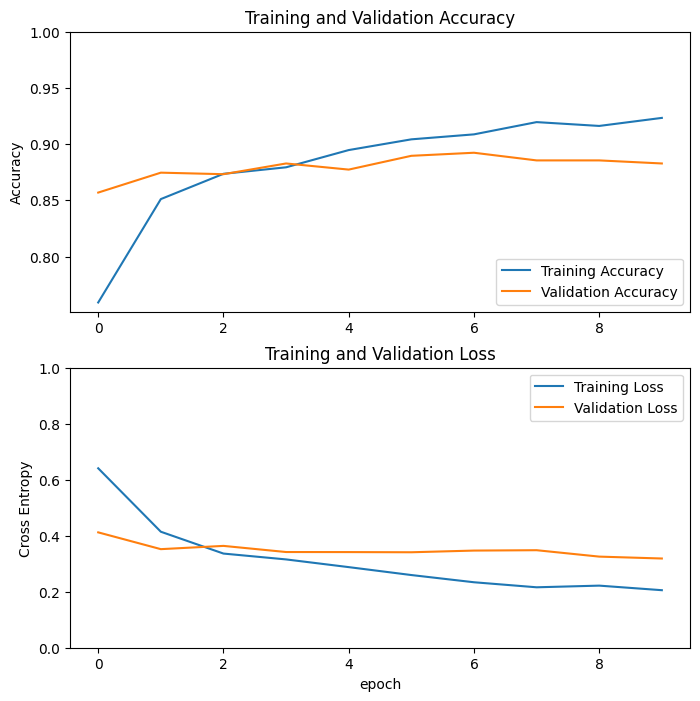

In [108]:
#results with fine-tuned transfer learning model
acc_transfer_tuned = history_transfer.history['accuracy']
val_acc_transfer_tuned = history_transfer.history['val_accuracy']

loss_transfer_tuned = history_transfer.history['loss']
val_loss_transfer_tuned = history_transfer.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc_transfer_tuned, label='Training Accuracy')
plt.plot(val_acc_transfer_tuned, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss_transfer_tuned, label='Training Loss')
plt.plot(val_loss_transfer_tuned, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [109]:
#predict on sunflower image
predictions = model_transfer.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 1s 601ms/step
This image most likely belongs to sunflowers with a 100.00 percent confidence.


## Fine-tuning the transfer learning model resulted in a final validation loss and accuracy of 0.2323 and 0.9183. This is improved on the non-tuned model. This model also still predicts the sunflowe with 100% confidence. In the next step, we will export our final model to TensorFlow Lite

In [110]:
#convert the trained model to TensorFLOW Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model_transfer)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)